In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

# Lightning Example

In [ ]:
class NN(pl.LightningModule):
    def __init__(self, n, n_hidden, n_out):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        )
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)  # Logs to history
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)  # Logs val loss
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    

In [17]:
# initialize a random target model + small noise for the NN class
N = 10000
n_in = 10
nh = 100
X = torch.randn(N, n_in) 
m = NN(n=n_in, n_hidden=nh, n_out=n_in)
m.eval()
Y = m(X) + 0.1*torch.randn(N, n_in)
Y = Y.detach()

In [21]:
# import dataloaders and split the data to train and test
from torch.utils.data import TensorDataset, DataLoader

N_train = int(0.8*N)
N_val = N - N_train

train_dataset = TensorDataset(X[:N_train], Y[:N_train])
val_dataset = TensorDataset(X[N_train:], Y[N_train:])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, persistent_workers=True)

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
new_model = NN(n=n_in, n_hidden=nh, n_out=n_in).to(device)

# train the model
trainer = pl.Trainer(max_epochs=10, enable_progress_bar=True, enable_model_summary=True, accelerator='mps')
trainer.fit(new_model, train_dataloader, val_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.1 K  | train
1 | loss  | MSELoss    | 0      | train
---------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 250/250 [00:00<00:00, 282.94it/s, v_num=17, train_loss_step=0.0107, val_loss=0.0117, train_loss_epoch=0.0114] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:00<00:00, 281.35it/s, v_num=17, train_loss_step=0.0107, val_loss=0.0117, train_loss_epoch=0.0114]


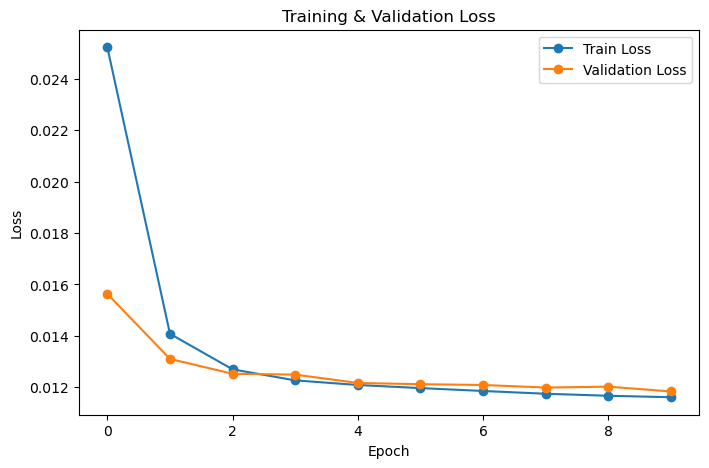

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load logs from TensorBoard
log_dir = "lightning_logs/version_15"  # Adjust the version number if needed
metrics = pd.read_csv(f"{log_dir}/metrics.csv")

# Filter loss values
train_loss = metrics[metrics['train_loss_epoch'].notna()][['epoch', 'train_loss_epoch']]
val_loss = metrics[metrics['val_loss'].notna()][['epoch', 'val_loss']]

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss['epoch'], train_loss['train_loss_epoch'], label="Train Loss", marker="o")
plt.plot(val_loss['epoch'], val_loss['val_loss'], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [15]:
print(torch.backends.mps.is_available())  

True
